# 实验一

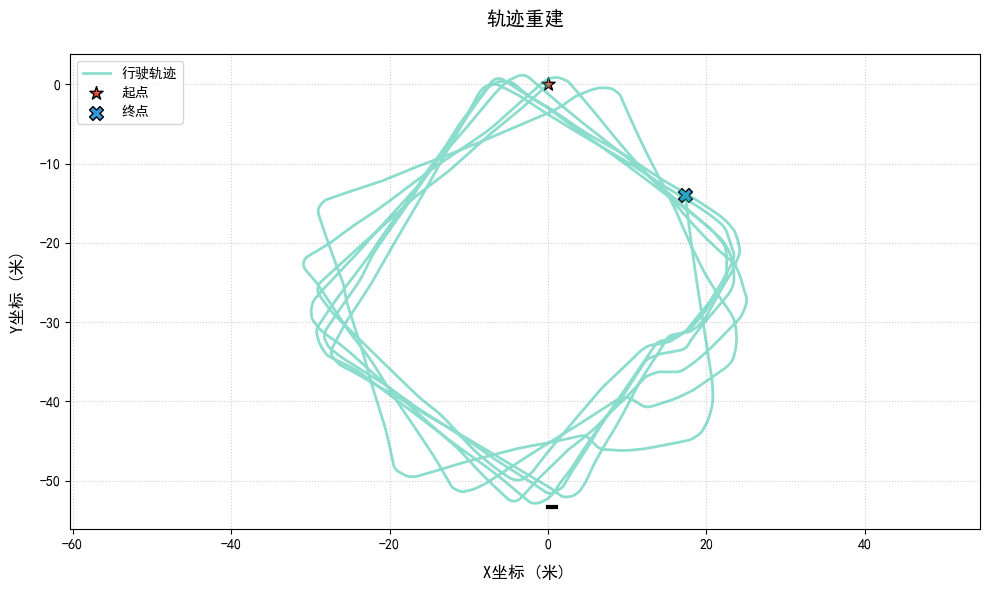

In [2]:
import math
import matplotlib.pyplot as plt

# ------------------------- IMU数据解析 -------------------------
def parse_imu_data(file_path):
    imu_data = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()             # 去除首尾空白字符
            if not line.startswith('IMU'):  # 忽略非IMU数据行
                continue                    
            parts = line.split()            # 按空格分割字段
            if len(parts) != 7:             # 字段完整性检查（必须包含7个字段）
                continue
            if int(parts[3]) < 180:         # 数据有效性检查（第三个字段 >=180有效）
                continue
            # 提取关键数据
            timestamp = int(parts[1])        # 时间戳（索引1）
            yaw = float(parts[6])            # 朝向角（索引6）
            imu_data.append({
                'timestamp': timestamp,
                'type': 'imu',
                'yaw_rad': math.radians(yaw) # 角度转弧度
            })
    return imu_data

# ------------------------- 编码器数据解析 -------------------------
def parse_encoder_data(file_path):
    encoder_data = []
    last_pulse = None
    with open(file_path, 'r') as f:
        for line in f:
            if not line.startswith('E '):   # 起始字符判断
                continue
            parts = line.split()
            if len(parts) < 4:              # 验证4个字段完整
                continue
            # 提取关键数据
            timestamp = int(parts[1])       # 时间戳（索引1）
            current_pulse = int(parts[3])   # 脉冲数（索引3）
            if last_pulse is not None:
                delta = current_pulse - last_pulse
                if delta < 0:
                    delta += 30000         # 脉冲溢出处理
                encoder_data.append({
                    'timestamp': timestamp,
                    'type': 'encoder',
                    'delta_pulse': delta
                })
            last_pulse = current_pulse
    return encoder_data

# ------------------------- 航位推算算法 -------------------------
def dead_reckoning(imu_data, encoder_data):
    # 合并数据集并按时间戳排序
    combined_data = sorted(imu_data + encoder_data, 
                         key=lambda x: x['timestamp'])
    # 初始化状态变量
    x, y = 0.0, 0.0                         # 初始坐标（米）
    current_yaw = 0.0                       # 初始朝向（弧度）
    pulse_to_meter = 0.003846154            # 每个脉冲对应0.003846154米
    trajectory = []
    # 模拟执行过程
    for data in combined_data:
        if data['type'] == 'imu':           # 更新当前朝向
            current_yaw = data['yaw_rad']
        elif data['type'] == 'encoder':     # 使用最新朝向计算位移分量
            delta_s = data['delta_pulse'] * pulse_to_meter
            dx = delta_s * math.cos(current_yaw)
            dy = delta_s * math.sin(current_yaw)
            x += dx
            y += dy
            trajectory.append((x, y))       # 更新坐标
    return trajectory

# ------------------------- 主程序 -------------------------
if __name__ == "__main__":

    imu_data = parse_imu_data('InterSense_X_20130903_195003.txt')
    encoder_data = parse_encoder_data('COMPort_X_20130903_195003.txt')

    # 轨迹计算
    trajectory = dead_reckoning(imu_data, encoder_data)
    
    
    # 轨迹可视化
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
    plt.figure(figsize=(10,6))
    xs, ys = zip(*trajectory)
    plt.plot(xs, ys, color='#1abc9c', alpha=0.5, linewidth=2, label='行驶轨迹')
    
    # 标记起点终点
    plt.scatter(xs[0], ys[0], c='#e74c3c', s=100, 
                marker='*', edgecolor='black', label='起点')
    plt.scatter(xs[-1], ys[-1], c='#3498db', s=100,
                marker='X', edgecolor='black', label='终点')
    
    # 图表样式设置
    plt.title('轨迹重建', fontsize=14, pad=20)
    plt.xlabel('X坐标 (米)', fontsize=12, labelpad=10)
    plt.ylabel('Y坐标 (米)', fontsize=12, labelpad=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(loc='upper left')
    plt.axis('equal')
    
    # 添加比例尺
    plt.plot([0,1], [min(ys)-0.5, min(ys)-0.5], 
             color='black', linewidth=3)
    
    
    plt.tight_layout()
    plt.show()

In [ ]:
# 将坐标转为nav文件
# nav文件说明：首行为title，从第二行开始为每一个时间戳信息，每行包括：时间戳，绕x轴旋转弧度，绕y轴旋转弧度，绕z轴旋转弧度，沿x轴平移距离，沿y轴平移距离，沿z轴平移距离
# 本例中，我们只考虑x和y轴的平移，因此z轴平移距离为0，绕x和y轴的旋转弧度为0

# 从COMPort_X_20130903_195003.txt中读取时间戳，因为时间戳的差表示运动，所以源数据中第一个时间戳不计入
import math


timestamps = []
for i in encoder_data:
    timestamps.append(i['timestamp'])
print(len(timestamps))

angle = math.radians(225)
rotation_matrix = [[math.cos(angle), math.sin(angle)],
                   [-math.sin(angle), math.cos(angle)]]

rotated_trajectory = []
for x, y in trajectory:
    rotated_x = rotation_matrix[0][0] * x + rotation_matrix[0][1] * y
    rotated_y = rotation_matrix[1][0] * x + rotation_matrix[1][1] * y
    rotated_trajectory.append([rotated_x, rotated_y])
trajectory = rotated_trajectory

with open('trajectory.nav', 'w') as f:
    f.write('time	gtrans.ang.x	ang.y	ang.z	shv.x	shv.y	shv.z\n')   # 写入标题
    # 初始化参数
    last_x, last_y = trajectory[0][0], trajectory[0][1]                         # 上一个时刻的x和y坐标，用于计算弧度
    ang_z = 0.0                                                                 # 绕z轴旋转弧度，不是相对值
    ang_x = ang_y = shv_z = 0                                                   # 这三个量在本例中不考虑，置为0
    f.write(f'{timestamps[0]}	{ang_x}	{ang_y}	{ang_z:.6f}	{last_x:.6f}	{last_y:.6f}	{shv_z}\n')
    
    for i in range(1, len(trajectory)):
        new_x, new_y = trajectory[i][0], trajectory[i][1]
        delta_x, delta_y = new_x - last_x, new_y - last_y                       # 计算本步的平移距离
        ang_z = math.atan2(delta_y, delta_x)+math.pi                            # 计算本步旋转角
        f.write(f'{timestamps[i]}	{ang_x}	{ang_y}	{ang_z:.6f}	{new_y:.6f}	{new_x:.6f}	{shv_z}\n')
        last_x, last_y = new_x, new_y                                           # 更新上一个时刻的坐标

In [ ]:
# 做个实验，测试nav中的旋转角是不是和绘图结果无关
# 首先读入ld.nav

data = []
with open('ld.nav', 'r') as f:
    title = f.readline()
    data.append(title)
    for line in f.readlines():
        l = line.split()
        l[3] = '0.000000'
        data.append(l.copy())
with open('ld_modified.nav', 'w') as f:
    f.write(data[0])
    # f.write('\n')
    for i in data[1:]:
        f.write(f'{i[0]} {i[1]} {i[2]} {i[3]} {i[4]} {i[5]} {i[6]}\n')
        
# 结论，确实无关

# 实验二

In [7]:
import struct
import math
import numpy as np
from PIL import Image

def read_lms_file(lms_filename):

    with open(lms_filename, 'rb') as f:
        # 读头部
        angle_range_bytes = f.read(4)                           # 读取4字节，得到激光扫描范围
        if len(angle_range_bytes) < 4:
            raise ValueError("Cannot read angle_range")
        angle_range = struct.unpack('<f', angle_range_bytes)[0] # 小端序将读取的字节数据转换为浮点数
        angle_res_bytes = f.read(4)                             # 读取4字节，得到激光扫描角分辨率
        angle_resolution = struct.unpack('<f', angle_res_bytes)[0]
        unit_bytes = f.read(4)                                  # 读取4字节，得到激光扫描距离值单位
        unit = struct.unpack('<f', unit_bytes)[0]
        
        # 计算每帧点数
        max_len = int(angle_range / angle_resolution + 1)       # 如果180°分辨率0.5则有361个点
        record_size = 4 + 2 * max_len                           # 4字节时间戳 + n个unsigned short(2字节)

        # 读取激光扫描数据
        scans = []
        while True:
            data = f.read(record_size)
            if not data or len(data) < record_size:
                break
            milli = struct.unpack('<i', data[0:4])[0]
            # 距离值
            ranges_raw = struct.unpack(f'<{max_len}H', data[4:])
            # 转换为米
            ranges_m = np.array(ranges_raw, dtype=np.float32) * (unit/1000)
            scans.append({'timestamp': milli, 'ranges': ranges_m})

    return angle_range, angle_resolution, unit, scans

read_lms_file("URG_X_20130903_195003.lms")

(180.0,
 0.5,
 100.0,
 [{'timestamp': 71403847,
   'ranges': array([  9.6     ,   9.6     ,   9.6     ,   9.6     ,   9.6     ,
            9.6     ,   9.6     ,   9.6     ,   9.6     ,   9.6     ,
            9.6     ,   9.6     ,   9.7     ,   9.7     ,   9.7     ,
            9.7     ,   9.7     ,   9.6     ,   9.6     ,   9.6     ,
            9.6     ,   9.7     ,   9.7     ,   9.7     ,   9.7     ,
            9.8     ,   9.8     ,   9.8     ,   9.8     ,   9.8     ,
            9.8     ,   9.900001,   9.900001,  10.      ,  10.      ,
           10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
           10.1     ,  10.1     ,  10.2     ,  10.2     ,  10.2     ,
           10.3     ,  10.3     ,  10.3     ,  10.3     ,  10.400001,
           10.400001,  10.5     ,  10.400001,  10.400001,  10.5     ,
           10.6     ,  10.6     ,  10.6     ,  10.8     ,  10.8     ,
           10.900001,  11.      ,  11.      ,  11.1     ,  11.1     ,
           11.1     ,  11.1     